In [1]:
import numpy as np
import sympy as sym
#from sympy.plotting import plot3d
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib import patheffects

In [2]:
#Почему-то у меня в голове был лаг, что f(x,y) = 0 и обязательно нужно находить координату по y. 
#Хоть эта часть кода и не нужна, я её оставлю. Может когда-нибудь пригодится
def GetCoordinateY (Func:sym.core.add.Add, x0):
    FuncSubs = sym.lambdify([x,y], Func)
    FuncStr = str(FunSubs(x0, y))
    CoordinatesY = sym.solve(FuncStr, y)
    return CoordinatesY

In [3]:
#Функция, которая считает градиент с использованием библиотеки sympy
def Gradient(Func, Coordinates:np.ndarray):
    #Дифференцируем по направлением функцию
    SymbolicPartialDerivativeX = Func.diff(x)
    SymbolicPartialDerivativeY = Func.diff(y)
    
    #Вычисляем значения производной в точках
    ValuePartialDerivativeX = SymbolicPartialDerivativeX.subs({x:Coordinates[0][0], y:Coordinates[0][1]})
    ValuePartialDerivativeY = SymbolicPartialDerivativeY.subs({x:Coordinates[0][0], y:Coordinates[0][1]})
    
    #Оборачиваем значения в np.ndarray
    GradientArray = np.array([
                    float(ValuePartialDerivativeX),
                    float(ValuePartialDerivativeY),
                    ])

    return GradientArray*(-1)

# Vanilla Gradient Descent 

In [4]:
def GradientDescent(Func, Coordinates:np.ndarray, LearningRate:float=0.12,
                Epsilon:float=1e-06) -> np.ndarray:
    
    GradientDescentPathArray = Coordinates
    
    while True:
        Coordinates = Coordinates - LearningRate*Gradient(Func, Coordinates)
        GradientDescentPathArray = np.append(GradientDescentPathArray, Coordinates, axis=0)
        if np.linalg.norm(Gradient(Func, Coordinates)) < Epsilon:
            break
            
    return GradientDescentPathArray

# Gradient Descent with a learning rate scheduler

In [5]:
def GradientDescentSchedule(Func, Coordinates:np.ndarray, LearningRate:float=0.5,
                           Epsilon:float=1e-6, NumberOfIterations=500) -> np.ndarray:
    
    GradientDescentPathArray = Coordinates
    
    
    for i in range(1, NumberOfIterations+1):
        if i%5 == 0:
            LearningRate *= (1/i)
        Coordinates = Coordinates - LearningRate*Gradient(Func, Coordinates)
        GradientDescentPathArray = np.append(GradientDescentPathArray, Coordinates, axis=0)
        if np.linalg.norm(Gradient(Func, Coordinates)) < Epsilon:
            break
    
    return GradientDescentPathArray

# Gradient Descent with momentum

In [6]:
def GradientDescentMomentum(Func, Coordinates:np.ndarray, LearningRate:float=0.05, Momentum:float=0.9,
                           Epsilon:float=1e-6, NumberOfIterations=500) -> np.ndarray:
    
    GradientDescentPathArray = Coordinates
    Velocity = np.zeros((1,Coordinates.size))
    
    for i in range (NumberOfIterations):
        Velocity = Momentum*Velocity + LearningRate*Gradient(Func, Coordinates)
        Coordinates -= Velocity
        GradientDescentPathArray = np.append(GradientDescentPathArray, Coordinates, axis=0)
        if np.linalg.norm(Gradient(Func, Coordinates)) < Epsilon:
            break
            
    return GradientDescentPathArray

# Adadelta
###### https://arxiv.org/pdf/1212.5701.pdf
"The method dynamically adapts over time using only first order information and has minimal computational overhead beyond vanilla stochastic gradient descent."

In [60]:
def Adadelta(Func, DecayRate:float=0.9, Epsilon:float=1e-6,
             NumberOfIterations=500, LearningRate:float=0) -> np.ndarray:
    
    #initializing path
    AdadeltaPathArray = Coordinates
    
    #initializing  accumulate variables
    EG = 0
    EDTheta = LearningRate
    
    for i in range (NumberOfIterations):
        EG = DecayRate*EG + (1 - DecayRate)*Gradient(Func, Coordinates)**2
        Update = (np.sqrt(EDTheta + Epsilon)/np.sqrt(EG + Epsilon))*Gradient(Func, Coordinates)
        #print(Update)
        AdadeltaPathArray = np.append(AdadeltaPathArray, Update, axis=0)
        EDTheta = DecayRate*EDTheta + (1 - DecayRate)*Update**2
    
    return AdadeltaPathArray

# Gradient Descent visualize function

In [37]:
def Visualize(Func, Coordinates):
    figure, auxiliary = plt.subplots(figsize=(10, 10))
    
    #Выбираем количество точек
    NumberOfPointsX = 1000
    NumberOfPointsY = 1000
    
    #Создаём вектора с точками равномерно распределёнными на [-3,3]
    SurveyVectorX = np.linspace(-3, 3, num=NumberOfPointsX)
    SurveyVectorY = np.linspace(-3, 3, num=NumberOfPointsY)
    
    #Соединяем полученные точки в две матрицы
    SurveyMatrixX, SurveyMatrixY = np.meshgrid(SurveyVectorX, SurveyVectorY)
    
    #Переводим символьную функцию в функцию на 'чистый' питоне и вычисляем значения
    PythonFunction = sym.lambdify((x,y), Func)
    SurveyMatrixZ = PythonFunction(SurveyMatrixX, SurveyMatrixY)
    GradientCoordinatesZ = PythonFunction(Coordinates[:,0],Coordinates[:,1])
    #print(FunctionObject)
    
    #Рисуем 'ШТУКУ'
    ContourLevels = np.unique(GradientCoordinatesZ) #Чтобы 'штука' сгенерировала уровни и не выкидывала ошибку
    
    PlotContour = auxiliary.contour(SurveyMatrixX, SurveyMatrixY, SurveyMatrixZ,
                                    levels=ContourLevels, colors='black')
    auxiliary.clabel(PlotContour, fmt="%2.1f", use_clabeltext=True)
    
    #Рисуем путь, который проделал градиентный спуск
    for i in range(len(Coordinates) - 1):
        plt.annotate('', xy=Coordinates[i + 1, :], xytext=Coordinates[i, :],
                 arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                 va='center', ha='center')
 
    #Введём ограничения на график
    auxiliary.set_xlim(-3, 3)
    auxiliary.set_ylim(-3, 3)
    
    plt.show()

## Трёхгорбая функция
$$f(x,y) = 2x^2_1 - 1.05x^4_1+\frac{1}{6}x^6_1 +x_1x_2+x^2_2$$

In [67]:
#Инициализируем символы для sympy
x,y = sym.symbols('x, y')
Func = sym.symbols('f', cls=sym.Function)

#Трёхгорбая функция 
Func = -2*x**2+1.05*x**4-sym.Rational(1,6)*x**6-x*y-y**2

#Первоначальные условия
x0, y0 = -0.75, 1.9
x1, y1 = -0.75, 0.8
Coordinates = np.array([[x0, y0]])
Coordinates2 = np.array([[x1, y1]])

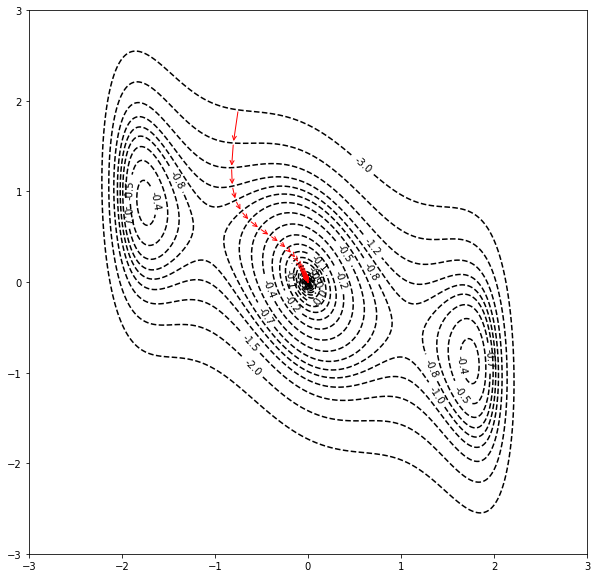

In [65]:
Visualize(Func, GradientDescent(Func, Coordinates))

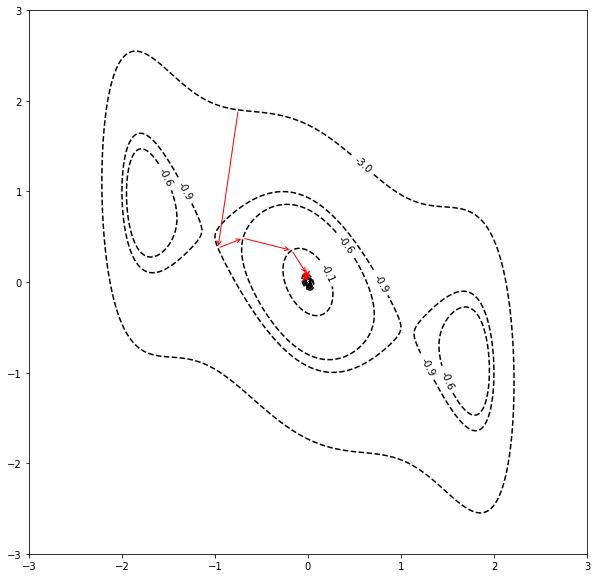

In [24]:
Visualize(Func, GradientDescentSchedule(Func, Coordinates))

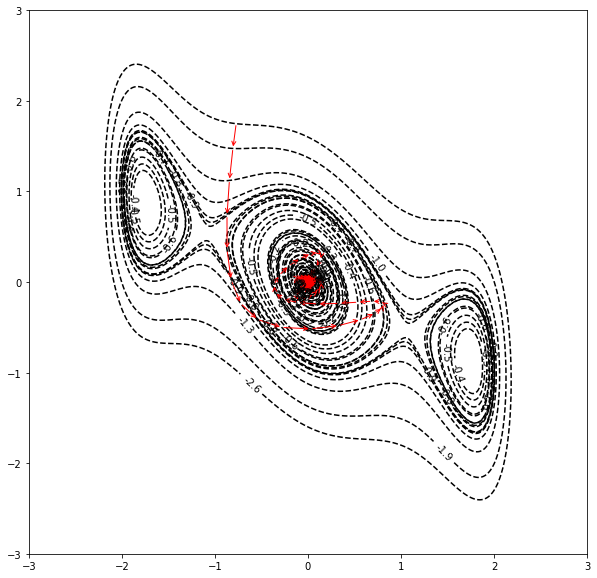

In [25]:
Visualize(Func, GradientDescentMomentum(Func, Coordinates))

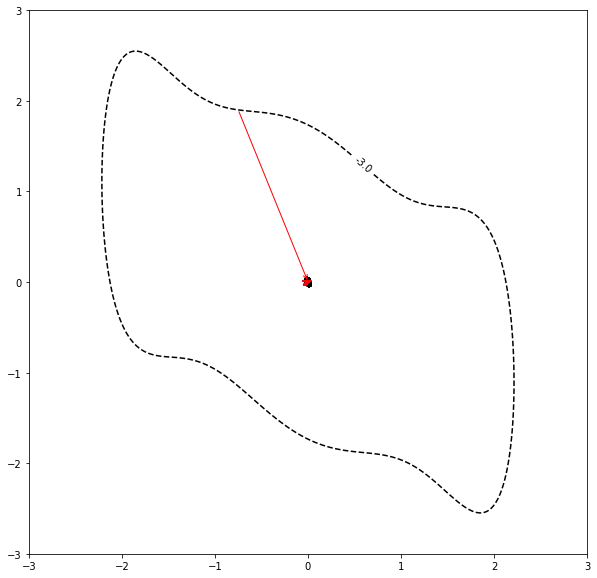

In [69]:
Visualize(Func, Adadelta(Func, Coordinates2))